In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import re
import string
import pickle
from collections import defaultdict
from tqdm import tqdm_notebook
from pandas_summary import DataFrameSummary

%load_ext autoreload
%autoreload 2
%matplotlib inline

pd.options.display.max_colwidth = 300
pd.options.display.max_columns = 30
pd.options.display.max_rows = 5000
seed = 42
np.random.seed(seed)

In [12]:
data_path = '../data/'
result_path = '../saved_results/Scenario3/run3/'

# Constants

In [3]:
SCENARIO2 = True
SCENARIO3 = False

if SCENARIO2 + SCENARIO3 != 1:
    raise Exception('Exactly 1 scenario should be selected')

# Get raw data and perform minimal pre-processing

In [4]:
df_raw = pd.read_csv(data_path + 'DIFI_Content_201811030832.csv', sep=';', encoding='latin1')

C:\Users\BJOVAS\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (1,3,7,8,10,12,13,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df_raw = df_raw.dropna(subset=['ProductCategoryLevel3UNSPSCCode', 'Product'])
df_raw.reset_index(inplace=True, drop=True)
df_raw.shape

(4148165, 22)

In [6]:
num_pattern = r'^[0-9]*((\.|\,)?[0-9]*)*$'
is_not_num = []
for product_name in df_raw['Product'].values:
    m = re.match(num_pattern, product_name)
    is_not_num.append(not bool(m))
df_raw = df_raw.loc[is_not_num]
df_raw.shape

(4148052, 22)

In [7]:
df_raw['Label'] = df_raw['ProductCategoryLevel3UNSPSCCode'].astype('int32')//100

In [8]:
df_raw['Label'] = df_raw['Label'].astype('str')

In [9]:
df_raw.drop_duplicates(inplace = True, subset=['Product', 'Label', 'VendorName', 'CatalogueID'])


In [10]:
df_raw.rename(columns={'Product': 'ProductName'}, inplace=True)

# Get result data

In [13]:
if SCENARIO2:
    catalog_scores = pickle.load(open(result_path + 'lstm_catalog_scores.pkl', 'rb'))

In [14]:
label_scores = pickle.load(open(result_path + 'lstm_label_scores.pkl', 'rb'))

In [15]:
product_label_map = pickle.load(open(result_path + 'lstm_product_label_map.pkl', 'rb'))

In [16]:
df = pd.read_pickle(result_path + 'scen2_lstm_results.pkl')
df.shape

(444645, 9)

In [17]:
df.head()

,ProductName,CatalogueID,Label,Predicted,Label count train,Label count test,PredLabel count train,PredLabel count test,CatalogSize
11,Plastakvarium/Terrarium,NO_BRIO-NO_HAMAR-NO-1,101317,101317,18.0,2.0,18,2.0,2307
17,Plastakvarium/Terrarium,NO_BRIO-NO_RANKO-NO-1,101317,101317,18.0,2.0,18,2.0,5865
106,"Slaghåv Ø28 cm, dybde 70 cm",NO_BRIO-NO_RANKO-NO-1,101917,101917,53.0,3.0,53,3.0,5865
107,Sommerfuglhåv,NO_BRIO-NO_RANKO-NO-1,101917,101917,53.0,3.0,53,3.0,5865
108,"Sommerfuglhåv, Ø24 cm, lengde 70cm",NO_BRIO-NO_RANKO-NO-1,101917,101917,53.0,3.0,53,3.0,5865


In [18]:
df.dropna(inplace=True)
df.shape

(444645, 9)

In [19]:
df.head()

,ProductName,CatalogueID,Label,Predicted,Label count train,Label count test,PredLabel count train,PredLabel count test,CatalogSize
11,Plastakvarium/Terrarium,NO_BRIO-NO_HAMAR-NO-1,101317,101317,18.0,2.0,18,2.0,2307
17,Plastakvarium/Terrarium,NO_BRIO-NO_RANKO-NO-1,101317,101317,18.0,2.0,18,2.0,5865
106,"Slaghåv Ø28 cm, dybde 70 cm",NO_BRIO-NO_RANKO-NO-1,101917,101917,53.0,3.0,53,3.0,5865
107,Sommerfuglhåv,NO_BRIO-NO_RANKO-NO-1,101917,101917,53.0,3.0,53,3.0,5865
108,"Sommerfuglhåv, Ø24 cm, lengde 70cm",NO_BRIO-NO_RANKO-NO-1,101917,101917,53.0,3.0,53,3.0,5865


In [20]:
df['Label count train'] = df['Label count train'].astype('int32')
df['Label count test'] = df['Label count test'].astype('int32')
df['PredLabel count test'] = df['PredLabel count test'].astype('int32')

In [21]:
df.shape

(444645, 9)

In [22]:
df = df[df['Label count train'] != 0] # remove samples with labels we never could predict as they are missing in train
df.shape

(444579, 9)

# Get map from label to description

In [23]:
label_description_map = {}
descriptions = df_raw['ProductCategoryLevel3Name'].values
for i, label in enumerate(df_raw['Label'].values):
    label_description_map[label] = descriptions[i]

In [24]:
len(label_description_map)

1073

In [25]:
df['Label desc'] = df['Label'].map(label_description_map)

In [26]:
df['Prediction desc'] = df['Predicted'].map(label_description_map)

In [27]:
df['Label acc'] = df['Label'].map(label_scores)

In [28]:
df['Pred label acc'] = df['Predicted'].map(label_scores)

In [29]:
if SCENARIO2:
    df['Cat acc'] = df['CatalogueID'].map(catalog_scores)

In [30]:
product_names = df['ProductName'].values
predicted = df['Predicted'].values

In [31]:
any_cond = []
for i, pred in enumerate(predicted):
    product_name = product_names[i]
    any_cond.append(pred in product_label_map[product_name])

In [32]:
df['Any'] = any_cond

In [33]:
df.sample(10)

,ProductName,CatalogueID,Label,Predicted,Label count train,Label count test,PredLabel count train,PredLabel count test,CatalogSize,Label desc,Prediction desc,Label acc,Pred label acc,Cat acc,Any
328379,Finnmarksloven - og retten til jorden i Finnmark Bokmål Innbundet,NO_NORLI-NO_NEDREEIK-NO-86331,551015,551115,1375878,226208,158056,22341,48966,Printed publications,Electronic publications and music,0.972153,0.982623,0.952722,True
1299292,VIGI C60 2P 25A 30MA A 26745,NO_ONNINEN-NO_EIDSVOLL-NO-94281,391216,391216,43558,6524,43558,6524,38790,Circuit protection devices and accessories,Circuit protection devices and accessories,0.999641,0.999641,0.999020,True
1922691,Mikrofiberklut 35x35cm gul,NO_NORENGROS-NO_NANNESTAD-NO-59274,471315,471315,4696,1024,4696,1024,4997,Cleaning rags and cloths and wipes,Cleaning rags and cloths and wipes,0.991816,0.991816,0.996798,True
2194725,CHAMP DUV LEROY 06 GR CR 12%,NO_NORGESGRUPPEN-NO_DRAMMEN-NO-1,502022,501819,939,17873,10259,3071,28955,Alcoholic beverages,Bread and biscuits and cookies,0.397621,0.951166,0.370679,False
187041,Demokratiets sorte hull : om spenningen mellom fag og politikk i velferdsstaten Bokmål Heftet,NO_NORLI-NO_FROGNK-NO-67025,551015,551015,1375878,226208,1375878,226208,23018,Printed publications,Printed publications,0.972153,0.972153,0.999696,True
2197227,HUDSON BABY BOURBON WHIS 46%,NO_NORGESGRUPPEN-NO_DRAMMEN-NO-1,502022,501817,939,17873,2240,1016,28955,Alcoholic beverages,Baking mixes and supplies,0.397621,0.912835,0.370679,False
3033894,Artiklar om litteratur Nynorsk Innbundet,NO_NORLI-NO_GJERDRUM-NO-64438,551015,551015,1375878,226208,1375878,226208,58006,Printed publications,Printed publications,0.972153,0.972153,0.999862,True
959712,"RQ 70°C 750V 2,5 HVIT GC",NO_ONNINEN-NO_EIDSVOLL-NO-94281,261216,261216,31323,3337,31323,3337,38790,Electrical cable and accessories,Electrical cable and accessories,0.999401,0.999401,0.999020,True
741264,"Ånden, dåpen, ilden Bokmål Heftet",NO_NORLI-NO_GJERDRUM-NO-64438,551015,551015,1375878,226208,1375878,226208,58006,Printed publications,Printed publications,0.972153,0.972153,0.999862,True
2304525,Norsk historie 1814-1860 : frå standssamfunn mot klassesamfunn Nynorsk Heftet,NO_NORLI-NO_EIDSVOLL-NO-64819,551015,551015,1375878,226208,1375878,226208,58006,Printed publications,Printed publications,0.972153,0.972153,0.999862,True


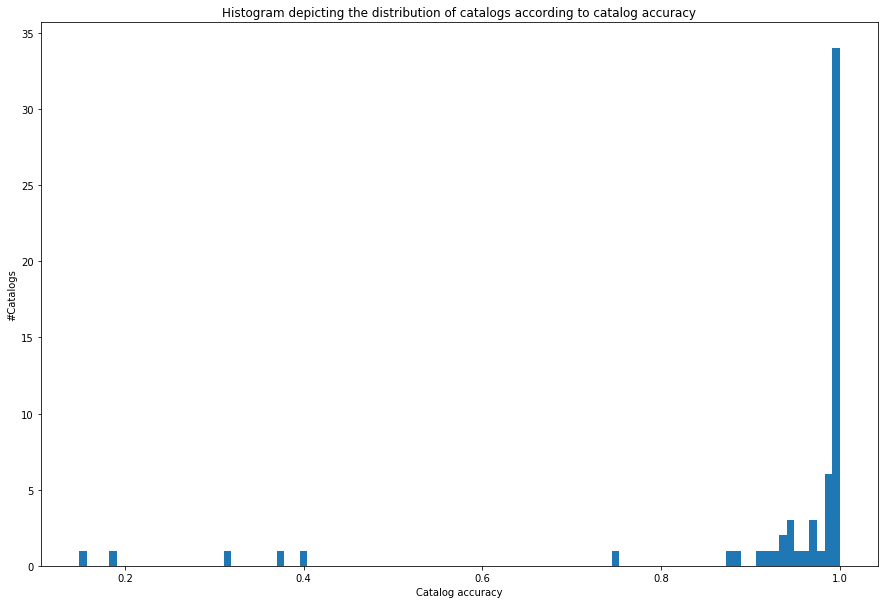

In [34]:
if SCENARIO2:
    plt.figure(figsize = (15,10))
    plt.xlabel('Catalog accuracy')
    plt.ylabel('#Catalogs')
    plt.title('Histogram depicting the distribution of catalogs according to catalog accuracy')
    plt.hist(list(catalog_scores.values()), bins=100)

    #plt.savefig('catalog_accuracy_histogram.png')

# Get the wrong predictions

In [35]:
df_wrong = df[~df['Any']]

In [36]:
df.shape, df_wrong.shape

((444579, 15), (26441, 15))

In [37]:
selection = df_wrong.sample(50).loc[:, ['ProductName', 'Label desc', 'Prediction desc', 'Label count train', 'Label count test', 'PredLabel count train', 'PredLabel count test', 'CatalogSize', 'Label acc', 'Pred label acc', 'Cat acc',]]

In [38]:
selection

,ProductName,Label desc,Prediction desc,Label count train,Label count test,PredLabel count train,PredLabel count test,CatalogSize,Label acc,Pred label acc,Cat acc
2169660,SEAWEED SØT SOYA OG SALT 5G ITSU,Instant mixes and supplies,Fish,1154,670,5701,1443,28955,0.934910,0.977471,0.370679
2195511,"PELLÉ MENETOU-SALON 12,5%",Alcoholic beverages,Bread and biscuits and cookies,939,17873,10259,3071,28955,0.397621,0.951166,0.370679
2210298,BØNNER PK 150 GR,Cauliflowers,Nuts and seeds,6,252,95,0,334,0.513413,NaN,0.317365
2196525,"CAPERITIF FW 17,5%",Alcoholic beverages,Baking mixes and supplies,939,17873,2240,1016,28955,0.397621,0.912835,0.370679
2189587,MONKEY BUS MO RIES 11%,Alcoholic beverages,Cakes and pies and pastries,939,17873,1345,199,28955,0.397621,0.873869,0.370679
2197913,ROBERTO CAVALLI VODKA 40%,Alcoholic beverages,Sauces and spreads and condiments,939,17873,7171,2120,28955,0.397621,0.968698,0.370679
1344700,MagNA Pure Compact Tip Tray Kit,Clinical and diagnostic analyzers and accessories and supplies,Nasoenteric tubes,1449,205,743,24,653,0.925073,0.845833,0.148545
2064427,KÅLROT TERNING 5KG 10X10 MM,Vegetables,Cucumbers,2060,344,42,0,335,0.496773,NaN,0.185075
1114691,Lysrør ULTIMATE LL 36W/830 (Std. Pakning-30 stk),Glass light bulbs,Lamps and lightbulbs,347,125,23954,3092,686,0.660000,0.994179,0.747813
2185132,CHIASSOBUIO 75CL,Alcoholic beverages,Desserts and dessert toppings,939,17873,3742,1092,28955,0.397621,0.913178,0.370679


In [ ]:
selection.loc[:, ['ProductName', 'Label desc', 'Prediction desc']].to_csv('test_scen3.csv', index=False, sep=';', header=False)

In [103]:
selection.to_pickle('feedback_selection_df_scen3.pkl')

In [242]:
test = pd.read_pickle('feedback_selection_df.pkl')